In [141]:
import pandas as pd
import numpy as nm


In [142]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [143]:
file = 'cifar-100-python/train'
file2 = 'cifar-100-python/test'
train = unpickle(file)
test = unpickle(file2)
# print (len(data.get(b'filenames')))
# print (data.keys())

In [144]:
# print(pd.Series(data.get(b'coarse_labels')))
# print(test.keys())
test_label_c=pd.Series(test.get(b'coarse_labels'))
_testdata = pd.Series(x for x in test.get(b'data'))
test_label_f=pd.Series(test.get(b'fine_labels'))
images = pd.Series(test.get(b'filenames'))
test_df = pd.DataFrame(images , columns=['images'])
test_df['c_label'] = test_label_c
test_df['f_label'] = test_label_f
test_df['data'] =_testdata

In [94]:
c_label = pd.Series(train.get(b'coarse_labels'))
f_label = pd.Series(train.get(b'fine_labels'))
images = pd.Series(train.get(b'filenames'))
_traindata = pd.Series(x for x in train.get(b'data'))

In [95]:
df = pd.DataFrame(images , columns=['images'])
df['c_label'] = c_label
df['f_label'] = f_label
df['data'] =_traindata

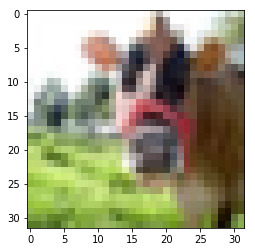

In [140]:
# df.head()
# print(_traindata[0].tolist())
import matplotlib.pyplot as plt
img = np.array(_traindata[0])
# transform it to a 3 x 1024 array, one row per color channel 
# and transpose it to a 1024 x 3 array, one row per rgb pixel
img = img.reshape(3, 1024).T
# reshape it so we can plot it as a 32 x 32 image with 3 color channels
img = img.reshape(32, 32, 3)

# plot
plt.imshow(img)
plt.show()

In [98]:
test_df.head()

,images,c_label,f_label,data
0,b'volcano_s_000012.png',10,49,"[199, 196, 195, 195, 196, 197, 198, 198, 199, ..."
1,b'woods_s_000412.png',10,33,"[113, 88, 72, 63, 72, 100, 131, 149, 139, 132,..."
2,b'seal_s_001803.png',0,72,"[61, 61, 67, 62, 64, 63, 70, 73, 78, 88, 85, 7..."
3,b'mushroom_s_001755.png',4,51,"[93, 88, 104, 90, 74, 70, 70, 75, 77, 60, 61, ..."
4,b'adriatic_sea_s_000653.png',10,71,"[80, 80, 82, 86, 92, 97, 96, 97, 98, 99, 100, ..."


In [99]:
df.isnull().any()

images     False
c_label    False
f_label    False
data       False
dtype: bool

In [100]:
test_df.isnull().any()

images     False
c_label    False
f_label    False
data       False
dtype: bool

In [131]:
train_label=df['c_label']
test_label = test_df['c_label']

In [102]:
from __future__ import division

import warnings
from scipy import linalg

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, as_float_array
from sklearn.externals import six
class ZCA(BaseEstimator, TransformerMixin):
    def __init__(self, regularization=1e-6, copy=False):
        self.regularization = regularization
        self.copy = copy
    
    def fit(self, X, y=None):
        """Compute the mean, whitening and dewhitening matrices.
        Parameters
        X : array-like with shape [n_samples, n_features]
            The data used to compute the mean, whitening and dewhitening
            matrices.
        """
        def warn_if_not_float(X, estimator='This algorithm'):
            if not isinstance(estimator, six.string_types):
                estimator = estimator.__class__.__name__
            if X.dtype.kind != 'f':
                warnings.warn("%s assumes floating point values as input, "
                              "got %s" % (estimator, X.dtype))
                return True
            return False
        X = check_array(X, accept_sparse=None, copy=self.copy,
                        ensure_2d=True)
        if warn_if_not_float(X, estimator=self):
            X = X.astype(np.float)
        self.mean_ = X.mean(axis=0)
        X_ = X - self.mean_
        cov = np.dot(X_.T, X_) / (X_.shape[0]-1)
        U, S, _ = linalg.svd(cov)
        s = np.sqrt(S.clip(self.regularization))
        s_inv = np.diag(1./s)
        s = np.diag(s)
        self.whiten_ = np.dot(np.dot(U, s_inv), U.T)
        self.dewhiten_ = np.dot(np.dot(U, s), U.T)
        return self

    def transform(self, X, y=None, copy=None):
        """Perform ZCA whitening
        X : array-like with shape [n_samples, n_features]
            The data to whiten along the features axis.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X - self.mean_, self.whiten_.T)

    def inverse_transform(self, X, copy=None):
        """Undo the ZCA transform and rotate back to the original
        representation
        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to rotate back.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X, self.dewhiten_) + self.mean_
__all__ = ['ZCA']


In [129]:
X = train.get(b'data')# data array
trf = ZCA().fit(X)
X_whitened = trf.transform(X)
X_whitened = (X_whitened-X_whitened.mean())/X_whitened.max()

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: ZCA assumes floating point values as input, got uint8


In [130]:
# print(X_whitened)
X_test = test.get(b'data')
trf = ZCA().fit(X_test)
X_whitened_test=trf.transform(X_test)
X_whitened_test = (X_whitened_test-X_whitened_test.mean())/X_whitened_test.max()

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: ZCA assumes floating point values as input, got uint8


In [122]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)


In [123]:
clf.fit(X_whitened,train_label)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [124]:
y_pred=clf.predict(X_whitened_test)

In [127]:
print(y_pred)
print(test_label.tolist())

[ 1100  2340 16860 ...,  3080  1900 12680]
[10980, 10660, 1440, 5020, 11420, 3840, 11300, 7280, 10460, 4000, 11420, 13500, 20620, 20380, 5800, 8860, 3840, 9940, 3400, 5060, 3400, 10980, 13500, 15580, 11420, 3320, 5780, 18160, 18160, 3400, 6400, 4220, 19820, 16860, 18120, 2460, 19160, 14220, 6500, 9740, 13260, 7480, 10980, 2460, 18120, 5440, 19820, 19160, 13500, 9340, 80, 7120, 3180, 5140, 14040, 1640, 11420, 18040, 8840, 20380, 14540, 15540, 11300, 17300, 7140, 14700, 8860, 3640, 13260, 3840, 13320, 19800, 2340, 2820, 1640, 1640, 3640, 3200, 14540, 5440, 11420, 16560, 3080, 7120, 15580, 20780, 16560, 10660, 14220, 2340, 5440, 7360, 15540, 11420, 18260, 11420, 17000, 13500, 9740, 14700, 13520, 5660, 17940, 1900, 8860, 20380, 10520, 9340, 5140, 18180, 6500, 6400, 15540, 4000, 3180, 11420, 18160, 8860, 5140, 18120, 20700, 3200, 11380, 3840, 10660, 6400, 11420, 17000, 3400, 14920, 14220, 3320, 1020, 17480, 10660, 2820, 11200, 13280, 18040, 10460, 80, 14220, 18040, 9740, 7480, 1900, 6500, 5

In [145]:
from sklearn.metrics import accuracy_score
